In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from collections import Counter
import re

# --- Caricamento Dati ---
path_annotation_embedding = 'MLPC2025_dataset/annotations_text_embeddings.npz'
path_annotations_csv = 'MLPC2025_dataset/annotations.csv'

# Carica gli embeddings
try:
    data_annotations = np.load(path_annotation_embedding)
    anno_embeddings = data_annotations["embeddings"]
    print(f"Embeddings caricati. Shape: {anno_embeddings.shape}") # Shape: (35826, embedding_dim) [cite: 8]
except FileNotFoundError:
    print(f"Errore: File embedding non trovato in {path_annotation_embedding}")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento degli embedding: {e}")
    exit()

# Carica le annotazioni testuali
try:
    annotations_df = pd.read_csv(path_annotations_csv)
    print(f"Annotazioni caricate. Shape: {annotations_df.shape}") # Dovrebbe avere 35826 righe [cite: 8]
    # Verifica che il numero di righe corrisponda agli embeddings
    if anno_embeddings.shape[0] != annotations_df.shape[0]:
        print("Attenzione: Il numero di embedding non corrisponde al numero di annotazioni!")
        # Potrebbe essere necessario un allineamento o un controllo dei dati
    # Estrai la colonna di testo
    annotation_texts = annotations_df['text'].tolist()
except FileNotFoundError:
    print(f"Errore: File annotazioni CSV non trovato in {path_annotations_csv}")
    exit()
except KeyError:
    print("Errore: La colonna 'text' non è presente nel file annotations.csv")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento delle annotazioni CSV: {e}")
    exit()


# --- Clustering con K-Means ---
num_clusters = 15 # Numero di cluster (k). Scegliere un valore appropriato!
print(f"\nEsecuzione di K-Means con k={num_clusters}...")

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10) # n_init='auto' o 10 per sopprimere warning futuri
# Nota: K-Means può essere sensibile all'inizializzazione, random_state assicura riproducibilità.
# n_init esegue l'algoritmo più volte con diversi centroidi iniziali.

try:
    cluster_labels = kmeans.fit_predict(anno_embeddings)
    print("Clustering completato.")
except Exception as e:
    print(f"Errore durante l'esecuzione di K-Means: {e}")
    exit()

# Aggiungi le etichette dei cluster al DataFrame delle annotazioni
annotations_df['cluster_label'] = cluster_labels

# --- Analisi dei Cluster ---
print(f"\n--- Analisi dei primi 5 Cluster (su {num_clusters}) ---")

for i in range(min(5, num_clusters)): # Analizziamo solo i primi 5 per brevità
    print(f"\nCluster {i}:")
    
    # Filtra le annotazioni per il cluster corrente
    cluster_annotations = annotations_df[annotations_df['cluster_label'] == i]['text']
    
    # Numero di annotazioni nel cluster
    print(f"  Numero di annotazioni: {len(cluster_annotations)}")
    
    # Mostra alcune annotazioni di esempio (le prime 5)
    print("  Esempi di annotazioni:")
    for text in cluster_annotations.head(5).tolist():
        print(f"    - {text}")
        
    # Analisi delle parole più frequenti (opzionale, ma utile)
    all_words = ' '.join(cluster_annotations.astype(str).tolist()).lower()
    # Rimuovi punteggiatura e numeri semplici per un conteggio più pulito
    words = re.findall(r'\b[a-z]+\b', all_words)
    # Rimuovi stop words comuni (molto basilare, potresti usare NLTK/spaCy per risultati migliori)
    common_stopwords = {'a', 'an', 'the', 'is', 'in', 'on', 'at', 'of', 'it', 'and', 'to', 'with', 'sound', 'sounds'}
    words = [word for word in words if word not in common_stopwords and len(word) > 2]
    
    word_counts = Counter(words)
    print("\n  Parole più frequenti (escluse stop words comuni):")
    for word, count in word_counts.most_common(10):
        print(f"    - {word}: {count}")

# --- Conclusioni Preliminari dal Clustering ---
# Qui potresti aggiungere commenti basati sull'output, ad esempio:
# - Cluster X sembra raggruppare suoni di 'engine' (motore).
# - Cluster Y contiene molte descrizioni di 'water' o 'waves' (acqua, onde).
# - Cluster Z è meno chiaro e contiene una varietà di suoni brevi/percussivi.
# - Ci sono cluster molto piccoli? Potrebbero essere outlier o suoni rari.
# - Ci sono cluster molto grandi e generici?

print("\n--- Fine Analisi Cluster ---")

Embeddings caricati. Shape: (35826, 1024)
Annotazioni caricate. Shape: (35826, 7)

Esecuzione di K-Means con k=15...
Clustering completato.

--- Analisi dei primi 5 Cluster (su 15) ---

Cluster 0:
  Numero di annotazioni: 1655
  Esempi di annotazioni:
    - An alarm siren sounding outdoors under windy conditions.
    - sound of wind
    - A gusty wind blows strongly through a narrow alley, causing trees to fall and releasing a crispy, crackling sound.
    - A womans voice appears in a very muffled way. 
    - A loud swooshing and rustling sound, gradually fading away indoors

  Parole più frequenti (escluse stop words comuni):
    - wind: 736
    - thunder: 301
    - noise: 249
    - blowing: 244
    - background: 179
    - muffled: 161
    - distance: 144
    - distant: 137
    - outdoors: 135
    - loud: 128

Cluster 1:
  Numero di annotazioni: 1451
  Esempi di annotazioni:
    - Continuous purrr like sound which resembles to be cat's purring sound.
    - Snoring in a rhythmic patter

In [2]:
annotations_df.head()

,task_id,filename,annotator,text,onset,offset,filename_unsafe,cluster_label
0,161977861,560761.mp3,5945971035380930099053858595454362549806990533...,bird twitters nearby with a high pitch two times,16.552368,17.271435,560761_tufted titmouse calling.mp3,6
1,161987165,240538.mp3,4916274343929406460752597829190197300566135449...,A cow bell clinging repeatedly,12.265866,15.420303,240538_AMB - Cowbell stable Stereowav.mp3,8
2,161989998,660337.mp3,8960534646813062318784592632173589349806817458...,A child speaks with a high-pitched voice,12.493984,13.315680,660337_Aeroplane Takeoff From Cabinwav.mp3,4
3,161978339,725686.mp3,4540509031938851510799116530500792274849113758...,A high pitch meowing coming from a cat,16.018221,16.991704,725686_Black Cat Talking.mp3,9
4,161985729,97606.mp3,1085174475307080254018414698413953957857995126...,An extremely loud brushing sound on a construc...,0.000000,1.626352,97606_jackhammer med distwav.mp3,2



--- Esecuzione PCA per la visualizzazione (riduzione a 2 dimensioni) ---
PCA completata.
Creazione del grafico a dispersione...
Grafico pronto per essere visualizzato.


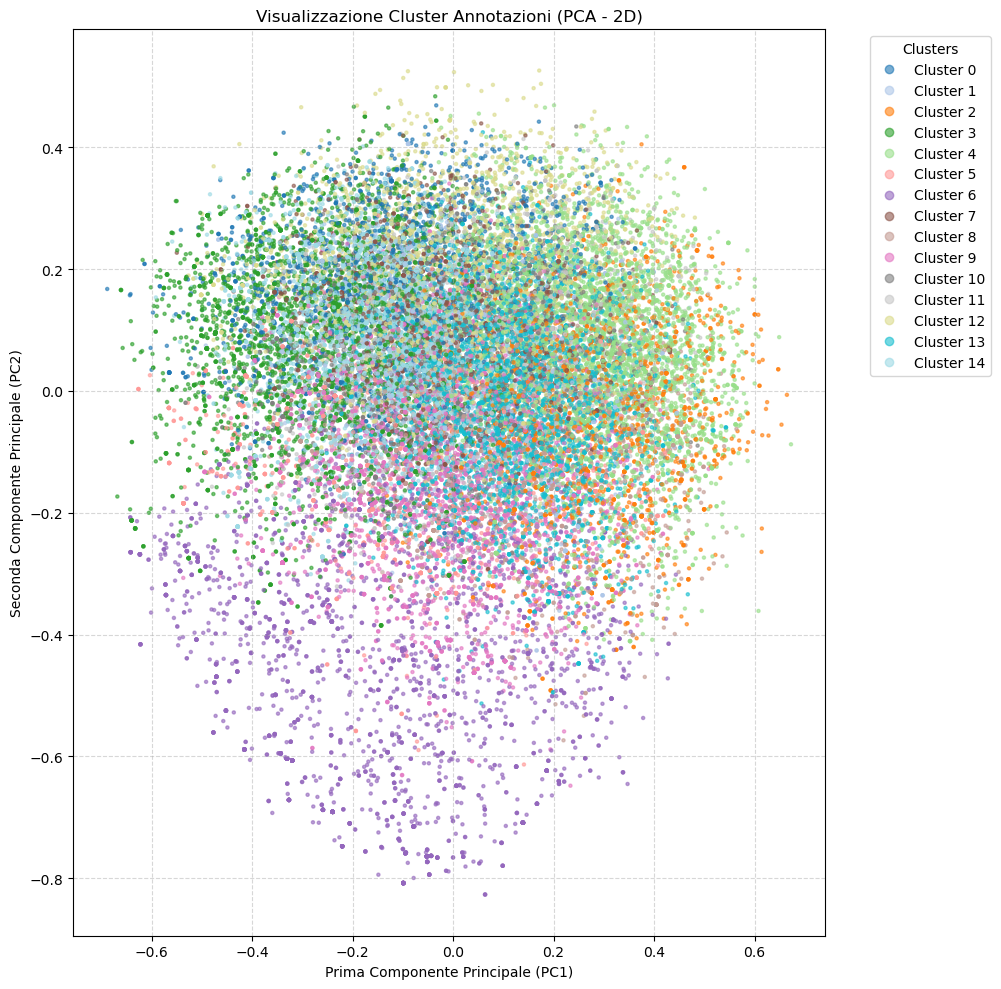

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings

# Ignora warning specifici di matplotlib su font mancanti (comune in alcuni ambienti)
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

# --- Visualizzazione con PCA ---
print("\n--- Esecuzione PCA per la visualizzazione (riduzione a 2 dimensioni) ---")

# Controlla se abbiamo abbastanza dati e cluster per plottare
if 'anno_embeddings' not in locals() or 'cluster_labels' not in locals():
    print("Errore: 'anno_embeddings' o 'cluster_labels' non trovati. Assicurati di aver eseguito il clustering prima.")
    exit()
if anno_embeddings.shape[0] < 2:
    print("Errore: Non ci sono abbastanza dati per eseguire PCA.")
    exit()


try:
    # Inizializza PCA per ridurre a 2 componenti
    pca = PCA(n_components=2, random_state=42)
    
    # Applica PCA agli embeddings
    embeddings_2d = pca.fit_transform(anno_embeddings)
    print("PCA completata.")

    # --- Creazione del Grafico ---
    print("Creazione del grafico a dispersione...")
    plt.figure(figsize=(12, 10))
    
    # Crea uno scatter plot con colori basati sulle etichette dei cluster
    # Usiamo una colormap per distinguere i cluster. 'viridis', 'plasma', 'tab20' sono buone opzioni.
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab20', s=5, alpha=0.6)
    
    # Aggiungi una legenda per i cluster
    # Creare una legenda per molti cluster può essere affollato, ma è utile.
    # Mostriamo una legenda solo se il numero di cluster non è eccessivo (es. <= 20)
    if num_clusters <= 20:
         # Crea handles per la legenda (un punto per ogni colore/cluster)
         handles, _ = scatter.legend_elements(prop="colors", num=num_clusters)
         # Etichette per la legenda
         legend_labels = [f'Cluster {i}' for i in range(num_clusters)]
         plt.legend(handles, legend_labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')


    # Aggiungi titoli e etichette agli assi
    plt.title('Visualizzazione Cluster Annotazioni (PCA - 2D)')
    plt.xlabel('Prima Componente Principale (PC1)')
    plt.ylabel('Seconda Componente Principale (PC2)')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Migliora il layout per evitare che la legenda si sovrapponga al grafico
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Lascia spazio a destra per la legenda con bbox_to_anchor

    # Mostra il grafico
    print("Grafico pronto per essere visualizzato.")
    plt.show()

except Exception as e:
    print(f"Errore durante la PCA o la creazione del grafico: {e}")


--- Identificazione 'Dog'/'Cat' ---
Indici 'Dog': 1601, Indici 'Cat': 711

--- Calcolo PCA ---


/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_14811/1649628802.py:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dog_indices = annotations_df[annotations_df['text'].str.contains(dog_pattern, case=False, regex=True, na=False)].index
/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_14811/1649628802.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cat_indices = annotations_df[annotations_df['text'].str.contains(cat_pattern, case=False, regex=True, na=False)].index


PCA completata in 0.29 secondi.

--- Calcolo t-SNE (potrebbe richiedere tempo) ---
t-SNE completata in 49.51 secondi.

--- Calcolo UMAP ---


/opt/anaconda3/envs/retina/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/retina/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/envs/retina/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/envs/retina/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! Th

UMAP completata in 22.38 secondi.

Creazione dei grafici...
Grafici pronti per essere visualizzati.


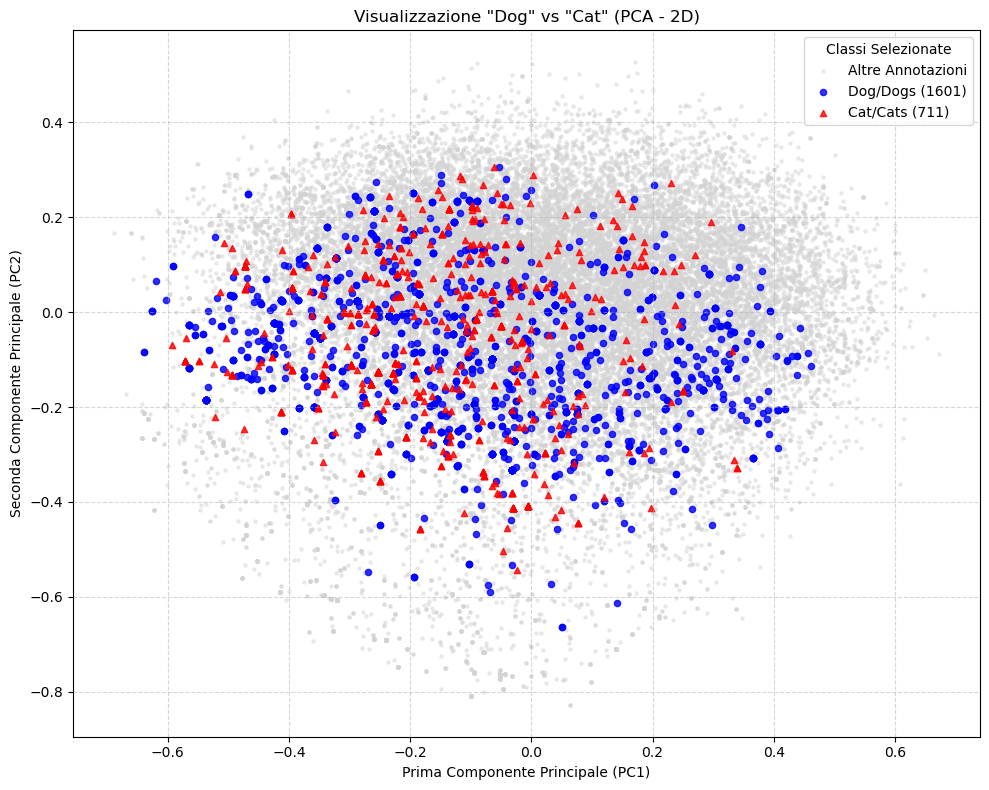

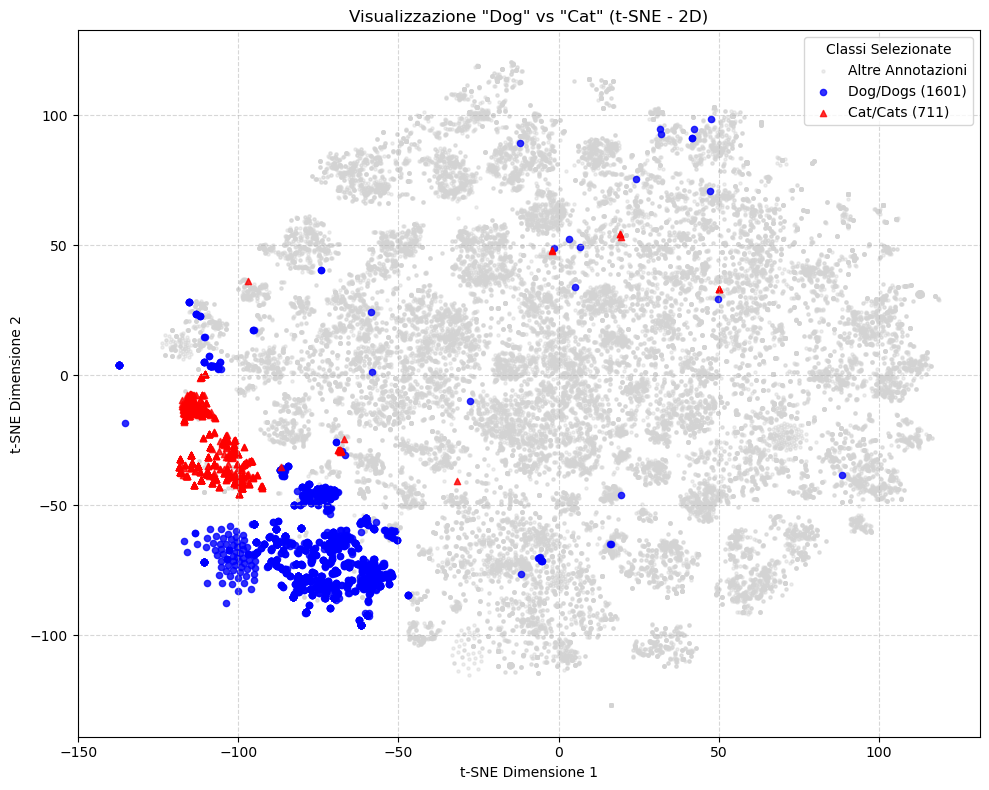

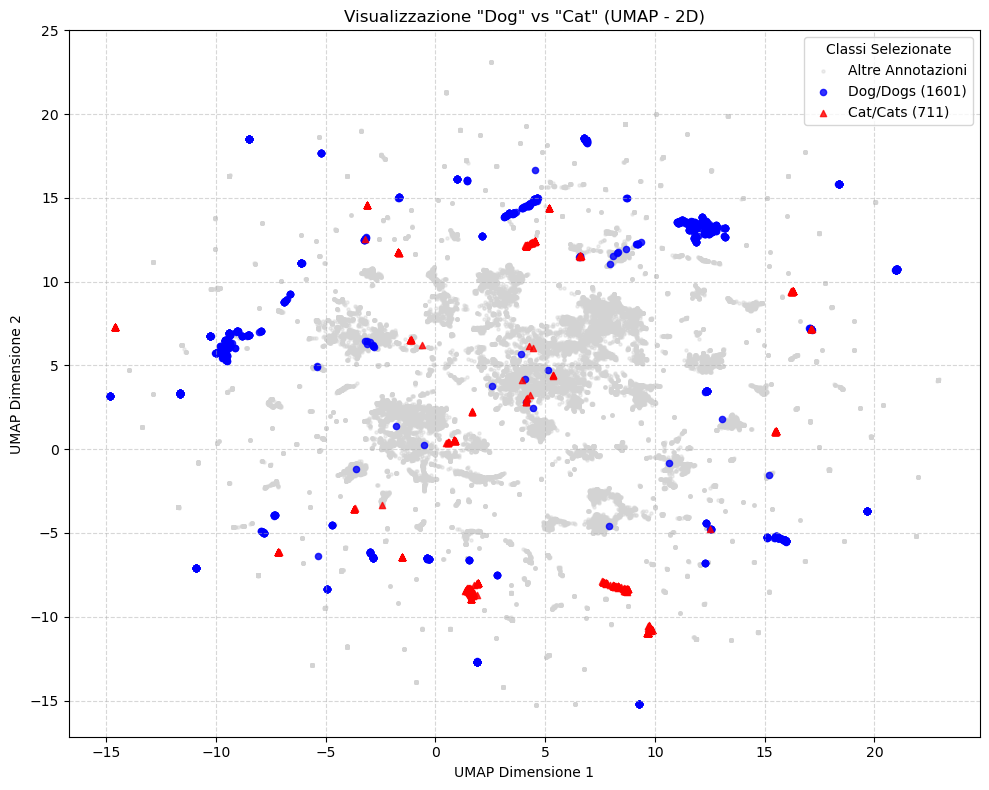


--- Fine visualizzazioni PCA, t-SNE, UMAP ---


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap # Assicurati che sia installato: pip install umap-learn
import warnings
import re
import time # Per misurare il tempo di esecuzione

# --- Prerequisiti ---
# Assicurati che 'annotations_df' e 'anno_embeddings' siano caricate
if 'annotations_df' not in locals() or 'anno_embeddings' not in locals():
     print("Errore: 'annotations_df' o 'anno_embeddings' non trovati.")
     print("Assicurati di aver eseguito il codice per caricare i dati prima.")
     exit()

# Ignora warning specifici
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
# Ignora FutureWarning comuni da UMAP/Numba
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Identificazione 'Dog'/'Cat' (come prima) ---
print("\n--- Identificazione 'Dog'/'Cat' ---")
dog_pattern = r'\b(dog|dogs)\b'
dog_indices = annotations_df[annotations_df['text'].str.contains(dog_pattern, case=False, regex=True, na=False)].index
cat_pattern = r'\b(cat|cats)\b'
cat_indices = annotations_df[annotations_df['text'].str.contains(cat_pattern, case=False, regex=True, na=False)].index
print(f"Indici 'Dog': {len(dog_indices)}, Indici 'Cat': {len(cat_indices)}")

# --- Calcolo delle Riduzioni Dimensionali ---

# 1. PCA
print("\n--- Calcolo PCA ---")
start_time = time.time()
pca = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca.fit_transform(anno_embeddings)
print(f"PCA completata in {time.time() - start_time:.2f} secondi.")

# 2. t-SNE
# NOTA: t-SNE può essere lento su ~36k punti x 1024 dimensioni!
print("\n--- Calcolo t-SNE (potrebbe richiedere tempo) ---")
start_time = time.time()
# Parametri comuni: perplexity (5-50), learning_rate, n_iter
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto',
            n_iter=1000, init='pca', random_state=42, n_jobs=-1) # Usa n_jobs=-1 per usare tutte le CPU
embeddings_tsne_2d = tsne.fit_transform(anno_embeddings)
print(f"t-SNE completata in {time.time() - start_time:.2f} secondi.")

# 3. UMAP
# NOTA: UMAP è generalmente più veloce di t-SNE
print("\n--- Calcolo UMAP ---")
start_time = time.time()
# Parametri comuni: n_neighbors, min_dist
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_umap_2d = reducer.fit_transform(anno_embeddings)
print(f"UMAP completata in {time.time() - start_time:.2f} secondi.")


# --- Funzione Helper per la Visualizzazione ---
def plot_dog_cat_embeddings(embeddings_2d, title, xlabel, ylabel, dog_indices, cat_indices):
    """Funzione per creare lo scatter plot con highlight di dog/cat."""
    plt.figure(figsize=(10, 8))

    # Seleziona le coordinate 2D per dog e cat
    dog_embeddings_2d_subset = embeddings_2d[dog_indices]
    cat_embeddings_2d_subset = embeddings_2d[cat_indices]

    # a) Plotta tutti i punti in grigio chiaro
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='lightgray', s=5, alpha=0.4, label='Altre Annotazioni')

    # b) Sovrapponi i punti 'dog'
    plt.scatter(dog_embeddings_2d_subset[:, 0], dog_embeddings_2d_subset[:, 1], c='blue', s=20, alpha=0.8, label=f'Dog/Dogs ({len(dog_indices)})', marker='o')

    # c) Sovrapponi i punti 'cat'
    plt.scatter(cat_embeddings_2d_subset[:, 0], cat_embeddings_2d_subset[:, 1], c='red', s=20, alpha=0.8, label=f'Cat/Cats ({len(cat_indices)})', marker='^')

    # Titoli, etichette, legenda
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Classi Selezionate", loc='best')
    plt.tight_layout()


# --- Creazione dei Grafici ---
print("\nCreazione dei grafici...")

# Grafico PCA
plot_dog_cat_embeddings(embeddings_pca_2d, 'Visualizzazione "Dog" vs "Cat" (PCA - 2D)',
                        'Prima Componente Principale (PC1)', 'Seconda Componente Principale (PC2)',
                        dog_indices, cat_indices)

# Grafico t-SNE
plot_dog_cat_embeddings(embeddings_tsne_2d, 'Visualizzazione "Dog" vs "Cat" (t-SNE - 2D)',
                        't-SNE Dimensione 1', 't-SNE Dimensione 2',
                        dog_indices, cat_indices)

# Grafico UMAP
plot_dog_cat_embeddings(embeddings_umap_2d, 'Visualizzazione "Dog" vs "Cat" (UMAP - 2D)',
                        'UMAP Dimensione 1', 'UMAP Dimensione 2',
                        dog_indices, cat_indices)

# Mostra tutti i grafici generati
print("Grafici pronti per essere visualizzati.")
plt.show()

print("\n--- Fine visualizzazioni PCA, t-SNE, UMAP ---")

### 4.3

In [5]:
import numpy as np
import pandas as pd
import os
import re
from tqdm.notebook import tqdm # Per la barra di progresso (opzionale, utile per processi lunghi)
# Se non usi Jupyter/IPython, puoi usare 'from tqdm import tqdm'

# --- Prerequisiti ---
# Assicurati che 'annotations_df' sia caricato e contenga le colonne 'filename', 'onset', 'offset'
if 'annotations_df' not in locals():
     print("Errore: DataFrame 'annotations_df' non trovato.")
     exit()
if not all(col in annotations_df.columns for col in ['filename', 'onset', 'offset']):
    print("Errore: Colonne 'filename', 'onset', 'offset' non trovate in annotations_df.")
    exit()

# --- Configurazioni ---
audio_features_dir = 'MLPC2025_dataset/audio_features/'
# Assumiamo che le feature siano calcolate con frame di 120ms come da PDF (slide 34)
# NOTA: Verifica se questo è corretto o se c'è un modo più preciso per mappare tempo a frame
FRAME_DURATION_SEC = 0.120
# Assumiamo che la chiave contenente l'array di feature nel file .npz sia 'features'
# NOTA: VERIFICA IL NOME ESATTO DELLA CHIAVE ESPLORANDO UN FILE .npz!
NPZ_FEATURE_KEY = 'embeddings'

# --- Funzione per ottenere il vettore medio di feature audio ---
def get_average_audio_features(annotation_row, base_path, frame_duration, feature_key):
    """
    Carica le feature audio per una riga di annotazione, seleziona i frame
    corrispondenti a onset/offset e calcola la media.
    """
    try:
        filename = annotation_row['filename']
        onset = annotation_row['onset']
        offset = annotation_row['offset']

        # Estrai l'ID dal filename (es. '12345.mp3' -> '12345')
        match = re.match(r'(\d+)\.mp3$', filename)
        if not match:
            # print(f"Warning: Formato filename non riconosciuto: {filename}")
            return None # O un vettore di NaN, o gestisci diversamente

        file_id = match.group(1)
        feature_filepath = os.path.join(base_path, f"{file_id}.npz")

        # Controlla se il file esiste
        if not os.path.exists(feature_filepath):
            # print(f"Warning: File feature non trovato: {feature_filepath}")
            return None

        # Carica il file .npz
        data = np.load(feature_filepath)
        if feature_key not in data:
             print(f"Errore: Chiave '{feature_key}' non trovata nel file {feature_filepath}. Chiavi disponibili: {list(data.keys())}")
             # Potresti voler uscire o restituire None/NaN qui
             return None
        audio_features = data[feature_key] # Shape: (num_frames, num_audio_features)

        # Calcola gli indici dei frame di inizio e fine
        # Nota: questo assume che il frame 0 corrisponda al tempo 0
        # Potrebbe essere necessario un aggiustamento se c'è un offset
        start_frame = int(np.floor(onset / frame_duration))
        end_frame = int(np.floor(offset / frame_duration)) # Indice esclusivo?

        # Gestisci casi limite/errori
        if offset <= onset or end_frame <= start_frame:
           # Se l'intervallo è nullo o negativo, o mappato allo stesso frame index,
           # prendi solo lo start_frame se valido, altrimenti nulla.
           if 0 <= start_frame < audio_features.shape[0]:
               selected_features = audio_features[start_frame:start_frame+1, :]
           else:
               # print(f"Warning: Intervallo non valido ({onset}-{offset}) o start_frame fuori range per {filename}")
               return None
        elif start_frame >= audio_features.shape[0] or start_frame < 0:
             # print(f"Warning: start_frame {start_frame} fuori range per {filename}")
             return None
        else:
            # Assicurati che end_frame non superi il numero di frame disponibili
            end_frame = min(end_frame, audio_features.shape[0])
            # Seleziona i frame (esclusivo alla fine, come slicing python)
            selected_features = audio_features[start_frame:end_frame, :]

        # Se non ci sono frame selezionati (es. intervallo molto breve mappato tra due indici)
        if selected_features.shape[0] == 0:
             # Prova a prendere solo lo start frame come fallback
             if 0 <= start_frame < audio_features.shape[0]:
                 selected_features = audio_features[start_frame:start_frame+1, :]
             else:
                 # print(f"Warning: Nessun frame selezionato e start_frame non valido per {filename} ({onset}-{offset})")
                 return None


        # Calcola la media lungo l'asse del tempo (asse 0)
        avg_features = np.mean(selected_features, axis=0)
        return avg_features

    except FileNotFoundError:
        # print(f"Warning: File feature non trovato (eccezione): {feature_filepath}")
        return None
    except Exception as e:
        print(f"Errore generico durante il processamento di {annotation_row.get('filename', 'N/A')}: {e}")
        return None


# --- Applica la funzione a tutte le annotazioni ---
print(f"\nCalcolo delle feature audio medie per {len(annotations_df)} annotazioni...")
# Usa tqdm per mostrare una barra di progresso
tqdm.pandas(desc="Processing Audio Features")
# Applica la funzione. Il risultato sarà una Serie di array numpy (o None)
average_audio_features_list = annotations_df.progress_apply(
    lambda row: get_average_audio_features(row, audio_features_dir, FRAME_DURATION_SEC, NPZ_FEATURE_KEY),
    axis=1
)

# --- Organizza i risultati ---
# Converti la lista di array/None in un array numpy 2D
# Prima, determina la dimensionalità delle feature audio da un risultato valido
feature_dim = None
for features in average_audio_features_list:
    if features is not None:
        feature_dim = features.shape[0]
        break

if feature_dim is None:
    print("Errore: Impossibile determinare la dimensionalità delle feature audio. Nessuna feature caricata correttamente.")
    exit()

print(f"Dimensionalità delle feature audio medie: {feature_dim}")

# Crea un array numpy pieno di NaN per ospitare i risultati
# Usiamo NaN per indicare le annotazioni per cui non è stato possibile calcolare le feature
num_annotations = len(annotations_df)
average_audio_features_array = np.full((num_annotations, feature_dim), np.nan)

# Popola l'array con i risultati calcolati
valid_feature_count = 0
for i, features in enumerate(average_audio_features_list):
    if features is not None:
        average_audio_features_array[i, :] = features
        valid_feature_count += 1

print(f"Feature audio medie calcolate per {valid_feature_count} su {num_annotations} annotazioni.")
print(f"Shape dell'array risultante: {average_audio_features_array.shape}")

# Ora hai 'average_audio_features_array'
# Ogni riga corrisponde a una riga in 'annotations_df'.
# Le righe con NaN indicano che le feature non sono state calcolate (file mancante, errore, intervallo non valido, etc.)

# Puoi anche aggiungerlo al DataFrame se preferisci (ma gli array numpy sono scomodi nelle celle)
# annotations_df['avg_audio_features'] = average_audio_features_list

# --- Prossimi Passi per Task 4.3 ---
# 1. Gestire i NaN: Decidi come trattare le annotazioni senza feature audio (escluderle dall'analisi di allineamento).
# 2. Cluster Audio Features: Applica un algoritmo di clustering (es. K-Means) a 'average_audio_features_array' (solo sulle righe valide).
# 3. Confronta Cluster: Analizza la corrispondenza tra i cluster audio e i cluster testuali (ottenuti in precedenza, es. da 'annotations_df['cluster_label']'). Tecniche come tabelle di contingenza, Adjusted Rand Index (ARI), Normalized Mutual Information (NMI) possono essere usate.

print("\n--- Fine caricamento e media feature audio ---")


Calcolo delle feature audio medie per 35826 annotazioni...


Processing Audio Features:   0%|          | 0/35826 [00:00<?, ?it/s]

Dimensionalità delle feature audio medie: 768
Feature audio medie calcolate per 35826 su 35826 annotazioni.
Shape dell'array risultante: (35826, 768)

--- Fine caricamento e media feature audio ---


In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix # o pandas.crosstab

# --- Prerequisiti ---
# Assicurati che esistano:
# - average_audio_features_array: L'array (35826, 768) calcolato prima.
# - annotations_df: Il DataFrame con la colonna 'cluster_label' (o un array separato con le etichette testuali)
# - num_clusters: Il numero di cluster usato per il testo (es. 20)

if 'average_audio_features_array' not in locals():
    print("Errore: 'average_audio_features_array' non trovato.")
    exit()
if 'annotations_df' not in locals() or 'cluster_label' not in annotations_df.columns:
     print("Errore: DataFrame 'annotations_df' o colonna 'cluster_label' (etichette testo) non trovati.")
     # Assumiamo che le etichette del cluster di testo siano nell'array 'cluster_labels'
     if 'cluster_labels' in locals() and len(cluster_labels) == average_audio_features_array.shape[0]:
         print("Userò l'array 'cluster_labels' per le etichette del testo.")
         text_cluster_labels = cluster_labels
     else:
         exit()
else:
    text_cluster_labels = annotations_df['cluster_label'].values

if 'num_clusters' not in locals():
    # Se num_clusters non è definito, prendilo dal numero di cluster testuali
    num_clusters = len(np.unique(text_cluster_labels))
    print(f"Numero di cluster non definito, impostato a {num_clusters} basato sui cluster testuali.")

# Verifica presenza NaN (anche se l'output precedente indicava 0 NaN)
nan_rows = np.isnan(average_audio_features_array).any(axis=1)
if np.sum(nan_rows) > 0:
    print(f"Attenzione: Trovate {np.sum(nan_rows)} righe con NaN nelle feature audio.")
    # Qui dovresti decidere come gestirle. Per ora, le escludiamo.
    print("Esclusione delle righe con NaN per il clustering audio e confronto.")
    valid_indices = ~nan_rows
    audio_features_to_cluster = average_audio_features_array[valid_indices, :]
    text_cluster_labels_filtered = text_cluster_labels[valid_indices]
else:
    print("Nessun NaN trovato nelle feature audio medie.")
    audio_features_to_cluster = average_audio_features_array
    text_cluster_labels_filtered = text_cluster_labels
    valid_indices = np.arange(len(text_cluster_labels)) # Tutti gli indici sono validi

# --- 1. Clusterizzare le Feature Audio ---
print(f"\n--- Clustering delle Feature Audio (K-Means, k={num_clusters}) ---")
kmeans_audio = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
audio_cluster_labels_filtered = kmeans_audio.fit_predict(audio_features_to_cluster)
print("Clustering audio completato.")

# Ricrea l'array completo delle etichette audio, inserendo -1 per le righe NaN escluse
audio_cluster_labels = np.full(len(text_cluster_labels), -1) # -1 indica non clusterizzato
audio_cluster_labels[valid_indices] = audio_cluster_labels_filtered


# --- 2. Confrontare i Cluster Audio e Testo ---
print("\n--- Confronto tra Cluster Audio e Testo (per annotazioni valide) ---")

# Calcola metriche solo sulle annotazioni valide (non NaN)
ari_score = adjusted_rand_score(text_cluster_labels_filtered, audio_cluster_labels_filtered)
nmi_score = normalized_mutual_info_score(text_cluster_labels_filtered, audio_cluster_labels_filtered)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

# Calcola e mostra la tabella di contingenza
print("\nTabella di Contingenza (prime righe/colonne per leggibilità):")
# Usiamo pandas.crosstab per una visualizzazione migliore
contingency_table = pd.crosstab(pd.Series(text_cluster_labels_filtered, name='Text Cluster'),
                                pd.Series(audio_cluster_labels_filtered, name='Audio Cluster'))

# Mostra solo una parte della tabella se è troppo grande
rows_to_show = min(10, num_clusters)
cols_to_show = min(10, num_clusters)
print(contingency_table.iloc[:rows_to_show, :cols_to_show])
if contingency_table.shape[0] > rows_to_show or contingency_table.shape[1] > cols_to_show:
    print("...")
    print(f"(Tabella completa: {contingency_table.shape[0]} righe x {contingency_table.shape[1]} colonne)")


# --- 3. Interpretazione (Guida) ---
print("\n--- Interpretazione dei Risultati ---")
print(f"ARI = {ari_score:.4f}, NMI = {nmi_score:.4f}")
if ari_score > 0.5:
    print("Valore ARI > 0.5 suggerisce un buon allineamento tra cluster testuali e audio.")
elif ari_score > 0.2:
    print("Valore ARI > 0.2 suggerisce un allineamento debole ma potenzialmente significativo.")
else:
    print("Valore ARI vicino a 0 o negativo suggerisce scarso o nessun allineamento oltre il caso.")

print("\nEsamina la tabella di contingenza:")
print("- Valori alti sulla diagonale (se i cluster sono ordinati in modo corrispondente, il che non è garantito) indicano buon allineamento.")
print("- Valori alti fuori dalla diagonale indicano che annotazioni simili per testo sono divise in diversi cluster audio, o viceversa.")
print("- Cerca righe (Text Cluster) con valori distribuiti su molte colonne (Audio Cluster) -> Quel concetto testuale ha suoni diversi.")
print("- Cerca colonne (Audio Cluster) con valori provenienti da molte righe (Text Cluster) -> Quel tipo di suono corrisponde a descrizioni diverse.")

print("\n--- Fine Task 4.3 ---")

Nessun NaN trovato nelle feature audio medie.

--- Clustering delle Feature Audio (K-Means, k=15) ---
Clustering audio completato.

--- Confronto tra Cluster Audio e Testo (per annotazioni valide) ---
Adjusted Rand Index (ARI): 0.1299
Normalized Mutual Information (NMI): 0.2582

Tabella di Contingenza (prime righe/colonne per leggibilità):
Audio Cluster     0    1    2    3    4    5    6     7    8    9
Text Cluster                                                     
0                36   16  472   37  373   32   12   160   39    3
1                22   28    4   18    7   13   76    22    2  149
2              1013   27    5   15  150   99    5    13   45    1
3                71  129   53  511  367  342  188   356  156   35
4               181  891   57  554  364  394  146   215  214   16
5                 4    0    8   36   46    9    1   161   35  896
6                 7    9   48   54  125   81    3  1905   76   14
7                21   48   11  429  119   15  659    26   87    